In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

In [2]:
fpaths = ['/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik1_Rb_0p8_Rmin_2dx/',
          '/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik58_Rb_0p8_Rmin_2dx/',
          '/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik89_Rb_0p8_Rmin_2dx/']
depths = ['Surface', '500m', '1500m']
tracks_full = {depth:[] for depth in depths}  # dictionary for tracks at each depth

for i,fpath in enumerate(fpaths):
    # go through each eddy file
    f = h5py.File(fpath + 'eddy_tracks.mat')

    # Arrange data into a list of dictionaries
    data = f['tracks']            # relevant variables
    varnames = list(f['tracks'])  # variable names
    ntracks = len(data['x1'])     # number of tracks (should match with length of data in 'x1')

    tracks = []
    # add dictionaries for each variable to the corresponding eddy index (0 - N-1)
    for itrack in range(ntracks):
        variables = {var:[] for var in varnames}  # initialize a dictionary with each variable name
        for var in varnames:
            # go through each variable
            if var[0:6] == 'shapes':
                # translate shapes data to list of numpy arrays (one array for each time step)
                coordinates = []                             # initialize list of coordinates
                numSteps = len(f[data[var][itrack,0]][(0)])  # number of timesteps
                # each timestep has its own hdf5 object reference, so append each step to a list
                for step in range(numSteps):
                    coords = np.array(f[f[data[var][itrack,0]][(0, step)]])
                    coordinates.append(coords)
                variables[var] = coordinates
            else:
                # translate data from hdf5 object reference to numpy array
                variables[var] = np.array(f[data[var][itrack,0]][(0)])
        tracks.append(variables)
    tracks_full[depths[i]] = tracks
    
print('Number of depths:', len(tracks_full))

Number of depths: 3


In [3]:
for depth in depths:
    print('num tracks:', len(tracks_full[depth]))

num tracks: 738
num tracks: 216
num tracks: 216


In [4]:
lifetime = 0                                   # lifetime filter (in hours)
cyclones = {depth:[] for depth in depths}      # dictionary of cyclonic eddies at each depth
anticyclones = {depth:[] for depth in depths}  # dictionary of anticyclonic eddies at each depth

for depth in depths:
    tracks = tracks_full[depth]
    cTracks = []
    aTracks = []
    for i, track in enumerate(tracks):
        timesteps = track['step'][-1] - track['step'][0]+1
        if timesteps >= lifetime and track['type'][0] == 1.:
            # add to list of cyclonic eddies
            cTracks.append(track)
        if timesteps >= lifetime and track['type'][0] == -1.:
            # add to list of anticyclonic eddies
            aTracks.append(track)
    cyclones[depth] = cTracks
    anticyclones[depth] = aTracks

print('Num Eddies')
for depth in depths:
    print(f'{depth:9}a: {len(anticyclones[depth])}  c: {len(cyclones[depth])}')

Num Eddies
Surface  a: 313  c: 425
500m     a: 115  c: 101
1500m    a: 104  c: 112


In [5]:
def haversine(lon1, lat1, lon2, lat2):
    """Calculates distance between two geographic coordinates (pos1, pos2)"""
    R = 6373.                                      # radius of Earth (in km)
    coords = np.float64([lon1, lat1, lon2, lat2])  # ensure coords are not integers
    lon1, lat1, lon2, lat2 = np.radians(coords)    # convert to radians
    
    dlon = lon2 - lon1  # distance btwn longitudes
    dlat = lat2 - lat1  # distance btwn latitudes
    
    # haversine formula
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R*c

def geodist(lons, lats):
    """Calculates total distance travelled from lists of longitudes and latitudes"""
    if len(lons) != len(lats):
        raise ValueError('Coordinate lists must have the same length.')
        
    dist = 0.
    for i in range(len(lons)):
        # sum distances
        currLon = lons[i]
        currLat = lats[i]
        if i > 0:
            dist += haversine(prevLon, prevLat, currLon, currLat)
        prevLon = currLon
        prevLat = currLat
    return dist

In [6]:
eddyTypes = ['anticyclone', 'cyclone']                     # eddy types
stats = {eddyType:[] for eddyType in eddyTypes}            # statistics for each eddy type
statTypes = ['Propagation', 'Rossby Number', 'Max Radius', 'Max Area', 'Lifetime']   # statistic values
units = ['km', '', 'km', 'km\u00b2', 'days']               # statistics units

# loop through cyclones and anticyclones
for eddyType in eddyTypes:
    print(eddyType.upper())
    stats[eddyType] = {depth:[] for depth in depths}  # set up stat dictionary for each depth
    for depth in depths:
        stats[eddyType][depth] = {statType:[] for statType in statTypes}
        if eddyType == 'cyclone':
            tracks = cyclones[depth]
        else:
            tracks = anticyclones[depth]
            
        for i, track in enumerate(tracks):
            # calculate distance
            dist = geodist(track['x1'], track['y1'])
            stats[eddyType][depth]['Propagation'].append(dist)
            
            # calculate Rossby number magnitude
            rossby = np.median(track['vort1']/track['f'])
            stats[eddyType][depth]['Rossby Number'].append(rossby)
            
            # calculate median eddy radius
            radius = np.median(track['rmax1'])
            stats[eddyType][depth]['Max Radius'].append(radius)
            
            # calculate median eddy radius
            area = np.median(track['aire1'])
            stats[eddyType][depth]['Max Area'].append(area)
            
            # calculate lifetime
            lftm = (track['step'][-1] - track['step'][0] + 1)/24
            stats[eddyType][depth]['Lifetime'].append(lftm)
        
        # print results
        print(depth)
        for i,statType in enumerate(statTypes):
            print(f'mean {statType:8}{np.mean(stats[eddyType][depth][statType]).round(decimals=3):>8} {units[i]}')
            print(f'min {statType:9}{np.min(stats[eddyType][depth][statType]).round(decimals=3):>8} {units[i]}')
            print(f'max {statType:9}{np.max(stats[eddyType][depth][statType]).round(decimals=3):>8} {units[i]}')
        print()

ANTICYCLONE
Surface
mean Propagation  34.893 km
min Propagation     0.0 km
max Propagation1480.328 km
mean Rossby Number  -0.191 
min Rossby Number  -1.085 
max Rossby Number  -0.039 
mean Max Radius   8.345 km
min Max Radius   3.032 km
max Max Radius  26.699 km
mean Max Area 263.485 km²
min Max Area   28.872 km²
max Max Area 2239.511 km²
mean Lifetime   0.932 days
min Lifetime    0.042 days
max Lifetime   30.375 days

500m
mean Propagation   57.15 km
min Propagation     0.0 km
max Propagation  693.41 km
mean Rossby Number   -0.08 
min Rossby Number  -0.269 
max Rossby Number  -0.017 
mean Max Radius   5.959 km
min Max Radius   3.279 km
max Max Radius  18.007 km
mean Max Area 128.258 km²
min Max Area   33.774 km²
max Max Area 1018.622 km²
mean Lifetime   4.029 days
min Lifetime    0.042 days
max Lifetime     32.0 days

1500m
mean Propagation  66.585 km
min Propagation     0.0 km
max Propagation 534.813 km
mean Rossby Number  -0.074 
min Rossby Number  -0.165 
max Rossby Number  -0.026 

In [33]:
from matplotlib.ticker import FormatStrFormatter

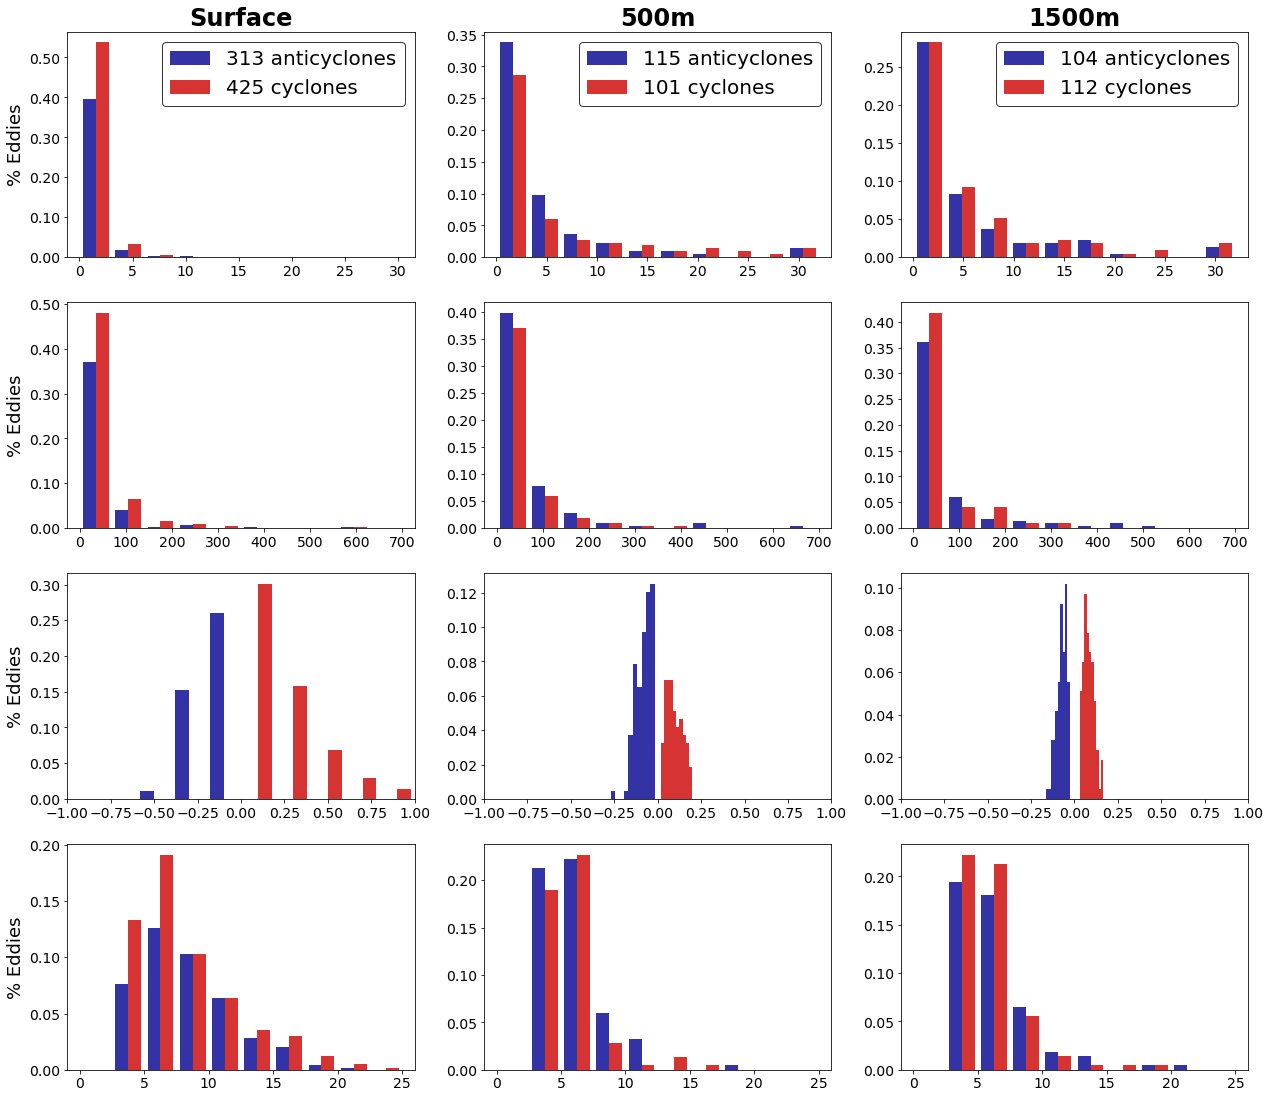

In [37]:
fig = plt.figure(figsize=(21.16,19.1))
plotStats = ['Lifetime', 'Propagation', 'Rossby Number', 'Max Radius']   # statistic values
plotUnits = ['days', 'km', '', 'km']               # statistics units

red = (1-0.2, 0,0,0.8)
blue = (0, 0, 1-0.4353,0.8)
colors = [blue, red]
j = 1
for i,plotStat in enumerate(plotStats):
    for depth in depths:
        nEddies = len(cyclones[depth]) + len(anticyclones[depth])              # total num eddies at this depth
        values = [stats[eddyType][depth][plotStat] for eddyType in eddyTypes]
        weights = [np.ones_like(value) / nEddies for value in values]          # normalize counts
        ax = fig.add_subplot(4,3,j)
        labels = [str(len(anticyclones[depth]))+' anticyclones', str(len(cyclones[depth]))+' cyclones']
        
        if plotStat == 'Propagation':
            ax.hist(values,
                    bins=10, color=colors, label=labels, weights=weights, range=(0,700))
        elif plotStat == 'Rossby Number':
            if depth != 'Surface':
                for k,eddyType in enumerate(eddyTypes):
                    ax.hist(values[k],
                            bins=10, color=colors[k], label=labels, weights=weights[k])
            else:
                ax.hist(values,
                            bins=10, color=colors, label=labels, weights=weights, range=(-1,1))
            ax.set_xlim(-1,1)
        elif plotStat == 'Max Radius':
            ax.hist(values,
                    bins=10, color=colors, label=labels, weights=weights, range=(0,25))
            plt.locator_params(axis='y', nbins=5)
        else:
            ax.hist(values,
                    bins=10, color=colors, label=labels, weights=weights)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        
        
        # Set the font size for axis tick labels
        for tick in ax.get_xticklabels():
            tick.set_fontsize(14)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(14)
        
        if j in [1,4,7,10,13]:
            ax.set_ylabel('% Eddies', fontsize=18)
        if j < 4:
            ax.set_title(depth, fontsize=24, fontweight='bold')
        if j<= 3:
            leg = plt.legend(fontsize=20)
            leg.get_frame().set_edgecolor('k')
        j += 1
plt.show()
fig_path = './figures/'
fname = 'stats.png'

fig.tight_layout()
fig.savefig(fig_path+fname, dpi=80)

In [8]:
fig_path = './figures/'
fname = 'stats.png'
plt.savefig(fig_path+fname)

<Figure size 432x288 with 0 Axes>